In [11]:
#Imports
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns

import nltk
from nltk.corpus import stopwords, wordnet
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import KernelPCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score,roc_curve, auc

from sklearn.exceptions import ConvergenceWarning
import warnings

from collections import Counter

import contractions

In [12]:
#Code à effacer je pense car pas utile pour le projet
nltk.data.path.append('/Users/r1/Desktop/Classification commentaires positifs et négatifs mémoire/nltk_data')


# **Étape 1**: Prétraitement et chargement des données


In [15]:
#Etape 1
# Initialisation des ressources
lemmatizer = WordNetLemmatizer()

# Mots de négation et intensificateurs importants à garder
important_words = {'not', 'no', 'never', 'none', "n't", 'very', 'so', 'too', 'most', 'just', 'only'}
base_stopwords = set(stopwords.words('english'))
stop_words = base_stopwords - important_words  # on retire les mots importants

#  Fonction pour mapper les tags POS Treebank vers WordNet
def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN  # par défaut



def expand_contractions(text):
    return contractions.fix(text)

# Fonction de nettoyage brut
def clean_text(text):
    text = re.sub(r'<.*?>', '', text)              # supprime les balises HTML
    text = re.sub(r'[^\w\s]', '', text)            # supprime la ponctuation
    text = text.lower()                            # passe en minuscules
    text = re.sub(r'\d+', '', text)                # supprime les chiffres
    text = re.sub(r'\s+', ' ', text).strip()       # supprime les espaces multiples
    return text

# Pipeline de prétraitement complet : nettoyage + tokenisation + POS-tagging + lemmatisation + stopword filtering
def preprocess_text(text):
    text = expand_contractions(text)     
    text = clean_text(text)
    tokens = word_tokenize(text)
    tagged_tokens = pos_tag(tokens)

    lemmatized = [
        lemmatizer.lemmatize(word, get_wordnet_pos(tag))
        for word, tag in tagged_tokens
        if word not in stop_words
    ]
    return ' '.join(lemmatized)

print(preprocess_text("I REALLY didn't like this movie!! It was <br> TOO long, with absolutely no plot. Just boring dialogues, and the acting? Terrible. I've seen better in student films..."))


really not like movie too long absolutely no plot just bore dialogue act terrible see well student film


In [16]:

#Test du prétraitement
print(preprocess_text("I REALLY didn't like this movie!! It was <br> TOO long, with absolutely no plot. Just boring dialogues, and the acting? Terrible. I've seen better in student films..."))
#Résultat attendu : "movie not very good not terrible either"
#really not like movie too long absolutely no plot just boring dialogue acting terrible seen better student films

really not like movie too long absolutely no plot just bore dialogue act terrible see well student film


In [17]:

#  Chargement du dataset + application du prétraitement
df = pd.read_csv('/Users/r1/Desktop/Classification commentaires positifs et négatifs mémoire/IMDB Dataset.csv',nrows=20000)
df['processed_review'] = df['review'].apply(preprocess_text)
df['label'] = df['sentiment'].map({'positive': 1, 'negative': 0})

print(df[['review', 'processed_review']].sample(3)) #Affiche un échantillon de 3 lignes


                                                  review  \
10842  Before I begin, let me tell you how GREAT this...   
15009  If you've ever had a mad week-end out with you...   
11986  A strange relationship between a middle-aged w...   

                                        processed_review  
10842  begin let tell great standup special sound pla...  
15009  ever mad weekend mate appreciate film excellen...  
11986  strange relationship middleaged woman transsex...  


## **Étape 2**: Analyse exploratoire du corpus 

Nombre total de mots avant prétraitement : 4622845
Nombre total de mots après prétraitement : 2448293
Nombre de mots uniques après prétraitement : 111127
Réduction globale après prétraitement : 47.04%
Nombre total de mots après prétraitement : 2448293
Nombre de mots uniques : 111127
3141 mots couvrent 80% des occurrences
5051 mots couvrent 85% des occurrences
9162 mots couvrent 90% des occurrences
20 mots les plus fréquents : [('not', 51616), ('movie', 39799), ('film', 36401), ('one', 21043), ('make', 17422), ('like', 17096), ('see', 16282), ('so', 15565), ('good', 14360), ('get', 14297), ('just', 13964), ('would', 12547), ('time', 11748), ('character', 10919), ('go', 10890), ('very', 10837), ('watch', 10568), ('bad', 10161), ('even', 9782), ('no', 9748)]


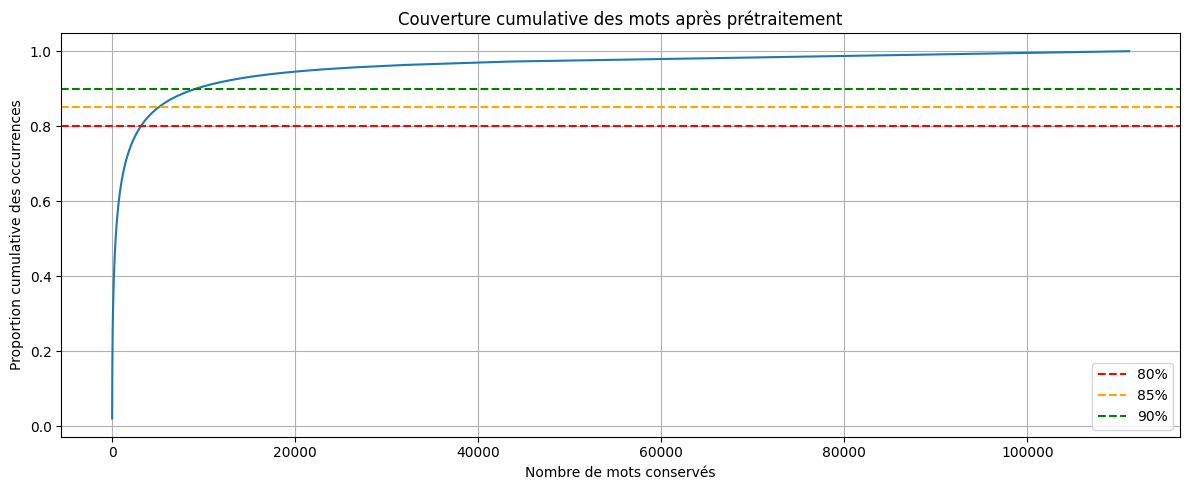

In [18]:
# Analyse du corpus : comparaison avant/après prétraitement 

# Statistiques avant prétraitement
raw_words = ' '.join(df['review']).split()
total_words_before = len(raw_words)

# Statistiques après prétraitement
cleaned_words = ' '.join(df['processed_review']).split()
total_words_after = len(cleaned_words)
unique_words_after = len(set(cleaned_words))

# Réduction de taille
reduction_ratio = 100 * (total_words_before - total_words_after) / total_words_before

print(f"Nombre total de mots avant prétraitement : {total_words_before}")
print(f"Nombre total de mots après prétraitement : {total_words_after}")
print(f"Nombre de mots uniques après prétraitement : {unique_words_after}")
print(f"Réduction globale après prétraitement : {reduction_ratio:.2f}%")

# Analyse fréquentielle après nettoyage 

# Comptage des mots
word_counts = Counter(cleaned_words)
total_words = sum(word_counts.values())
unique_words = len(word_counts)

# Tri des fréquences et cumul
sorted_counts = sorted(word_counts.values(), reverse=True)
cum_counts = np.cumsum(sorted_counts)

# Seuils de couverture
coverage_80 = np.argmax(cum_counts >= 0.80 * total_words) + 1
coverage_85 = np.argmax(cum_counts >= 0.85 * total_words) + 1
coverage_90 = np.argmax(cum_counts >= 0.90 * total_words) + 1

# Affichage des stats
print(f"Nombre total de mots après prétraitement : {total_words}")
print(f"Nombre de mots uniques : {unique_words}")
print(f"{coverage_80} mots couvrent 80% des occurrences")
print(f"{coverage_85} mots couvrent 85% des occurrences")
print(f"{coverage_90} mots couvrent 90% des occurrences")
print("20 mots les plus fréquents :", word_counts.most_common(20))

# Courbe de couverture cumulative

plt.figure(figsize=(12, 5))
plt.plot(np.arange(1, len(cum_counts) + 1), cum_counts / total_words)
plt.axhline(0.80, color='r', linestyle='--', label="80%")
plt.axhline(0.85, color='orange', linestyle='--', label="85%")
plt.axhline(0.90, color='g', linestyle='--', label="90%")
plt.xlabel("Nombre de mots conservés")
plt.ylabel("Proportion cumulative des occurrences")
plt.title("Couverture cumulative des mots après prétraitement")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## **Étape 3** : Split du texte prétraité 

In [20]:
# On récupère les textes prétraités et les étiquettes binaires
X_text = df['processed_review']# Corpus prétraité (lemmatisé, nettoyé)
y = df['label'].values # Labels : 1 = positif, 0 = négatif

# On sépare le corpus en un jeu d'entraînement et un jeu de test
# 70% pour l'entraînement, 30% pour le test
X_text_train, X_text_test, y_train, y_test = train_test_split(X_text, y, test_size=0.3, random_state=42,stratify=y)

## **Étape 4** : Vectorisation (BoW sur train uniquement)

In [21]:
# On vectorise uniquement le jeu d'entraînement pour éviter toute fuite de données
# On limite le vocabulaire aux 7 000 mots les plus fréquents dans le corpus d'entraînement
vectorizer = CountVectorizer(max_features=10000)
X_train = vectorizer.fit_transform(X_text_train).toarray()
X_test = vectorizer.transform(X_text_test).toarray()

## **Étape 5** : Analyse spectrale (sur le jeu d'entraînement uniquement)

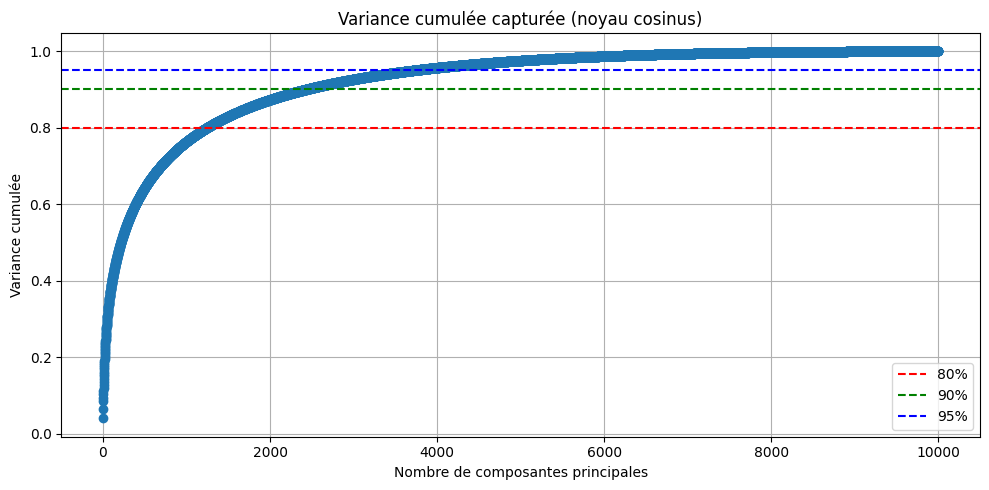

1244 composantes suffisent à capturer 80% de la variance.
1709 composantes suffisent à capturer 85% de la variance.
2255 composantes suffisent à capturer 89% de la variance.
2429 composantes suffisent à capturer 90% de la variance.
3723 composantes suffisent à capturer 95% de la variance.


In [23]:
# Construction du Kernel PCA avec un nombre de composantes maximal (utile uniquement pour l'analyse spectrale)
kpca_full = KernelPCA(
    kernel='cosine',
    fit_inverse_transform=False,
    n_components=min(X_train.shape[0], X_train.shape[1])  # ne pas dépasser la taille max de X_train
)

# Ajustement du noyau sur les données d'entraînement (sans réduction ici)
X_kpca_full = kpca_full.fit_transform(X_train)

# Récupération des valeurs propres
eigenvalues = kpca_full.eigenvalues_

# Calcul de la variance cumulée
explained_variance_ratio = np.cumsum(eigenvalues) / np.sum(eigenvalues)

# Tracé de la variance cumulée
plt.figure(figsize=(10, 5))
plt.plot(
    np.arange(1, len(explained_variance_ratio) + 1),
    explained_variance_ratio,
    marker='o'
)
plt.axhline(0.80, color='red', linestyle='--', label='80%')
plt.axhline(0.90, color='green', linestyle='--', label='90%')
plt.axhline(0.95, color='blue', linestyle='--', label='95%')
plt.title("Variance cumulée capturée (noyau cosinus)")
plt.xlabel("Nombre de composantes principales")
plt.ylabel("Variance cumulée")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Affichage des seuils de variance capturée
for seuil in [0.80, 0.85, 0.89, 0.90, 0.95]:
    k = np.argmax(explained_variance_ratio >= seuil) + 1
    print(f"{k} composantes suffisent à capturer {int(seuil * 100)}% de la variance.")


## **Étape 6** : Réduction de dimension avec kernel PCA (cosine) sur les données d'entrainement uniquement


In [25]:
# Nombre de composantes principales choisi en fonction de l’analyse spectrale précédente
n_composantes = 2429

# Application du Kernel PCA : ajustement uniquement sur le jeu d'entraînement
kpca = KernelPCA(n_components=n_composantes, kernel='cosine')

# Transformation du jeu d'entraînement
X_kpca_train = kpca.fit_transform(X_train)

# Transformation du jeu de test (utilise le même modèle entraîné sur X_train)
X_kpca_test = kpca.transform(X_test)


## **Étape 7** : Création et entraînement des modèles 

In [26]:
results = []

# Fonction pour stocker les résultats
def add_result(name, y_true, y_pred):
    acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    results.append({
        'Modèle': name,
        'Accuracy': acc,
        'F1-score': f1
    })

# KNN 
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)
add_result("KNN (sans PCA)", y_test, knn.predict(X_test))

knn_kpca = KNeighborsClassifier(n_neighbors=5)
knn_kpca.fit(X_kpca_train, y_train)
add_result("KNN (avec PCA)", y_test, knn_kpca.predict(X_kpca_test))

# Régression Logistique 
logreg = LogisticRegression(max_iter=1000)
logreg.fit(X_train, y_train)
add_result("LogReg (sans PCA)", y_test, logreg.predict(X_test))

logreg_kpca = LogisticRegression(max_iter=1000)
logreg_kpca.fit(X_kpca_train, y_train)
add_result("LogReg (avec PCA)", y_test, logreg_kpca.predict(X_kpca_test))

# SVM RBF 
svm = SVC(kernel='rbf', probability=True)
svm.fit(X_train, y_train)
add_result("SVM (sans PCA)", y_test, svm.predict(X_test))

svm_kpca = SVC(kernel='rbf', probability=True)
svm_kpca.fit(X_kpca_train, y_train)
add_result("SVM (avec PCA)", y_test, svm_kpca.predict(X_kpca_test))



## **Étape 8** : Résultats comparatifs des modèles




              Modèle  Accuracy  F1-score
0     KNN (sans PCA)  0.633833  0.562263
1     KNN (avec PCA)  0.707167  0.688530
2  LogReg (sans PCA)  0.865333  0.865063
3  LogReg (avec PCA)  0.871000  0.870612
4     SVM (sans PCA)  0.867500  0.869136
5     SVM (avec PCA)  0.873667  0.872733


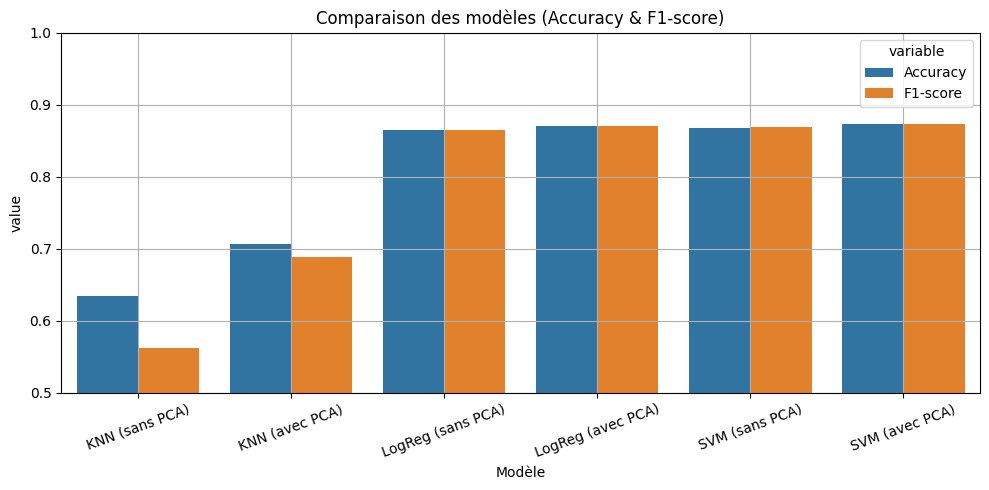

'\n# Courbes ROC \n\nmodels_comparaison = {\n    "Logistic Regression": (logreg, X_test, logreg_kpca, X_kpca_test),\n    "SVM (RBF)": (svm, X_test, svm_kpca, X_kpca_test),\n    "KNN": (knn, X_test, knn_kpca, X_kpca_test),\n}\n\nfig, axes = plt.subplots(1, 3, figsize=(18, 5))\n\nfor ax, (name, (model_no_pca, X_eval_no_pca, model_pca, X_eval_pca)) in zip(axes, models_comparaison.items()):\n    \n    for label, model, X_eval in [("Sans PCA", model_no_pca, X_eval_no_pca),\n                                 ("Avec PCA", model_pca, X_eval_pca)]:\n        # Choix du score selon le modèle\n        if hasattr(model, "predict_proba"):\n            y_score = model.predict_proba(X_eval)[:, 1]\n        elif hasattr(model, "decision_function"):\n            y_score = model.decision_function(X_eval)\n        else:\n            continue  # Évite une erreur si le modèle ne fournit aucun score\n\n        # Calcul des métriques ROC\n        fpr, tpr, _ = roc_curve(y_test, y_score)\n        auc_score = auc

In [ ]:

# Résumé des scores dans un DataFrame
df_results = pd.DataFrame(results)
print(df_results)

# Barplot Accuracy & F1-score
plt.figure(figsize=(10, 5))
sns.barplot(
    data=df_results.melt(id_vars="Modèle"),
    x="Modèle",
    y="value",
    hue="variable"
)
plt.title("Comparaison des modèles (Accuracy & F1-score)")
plt.ylim(0.5, 1)
plt.xticks(rotation=20)
plt.grid(True)
plt.tight_layout()
plt.show()


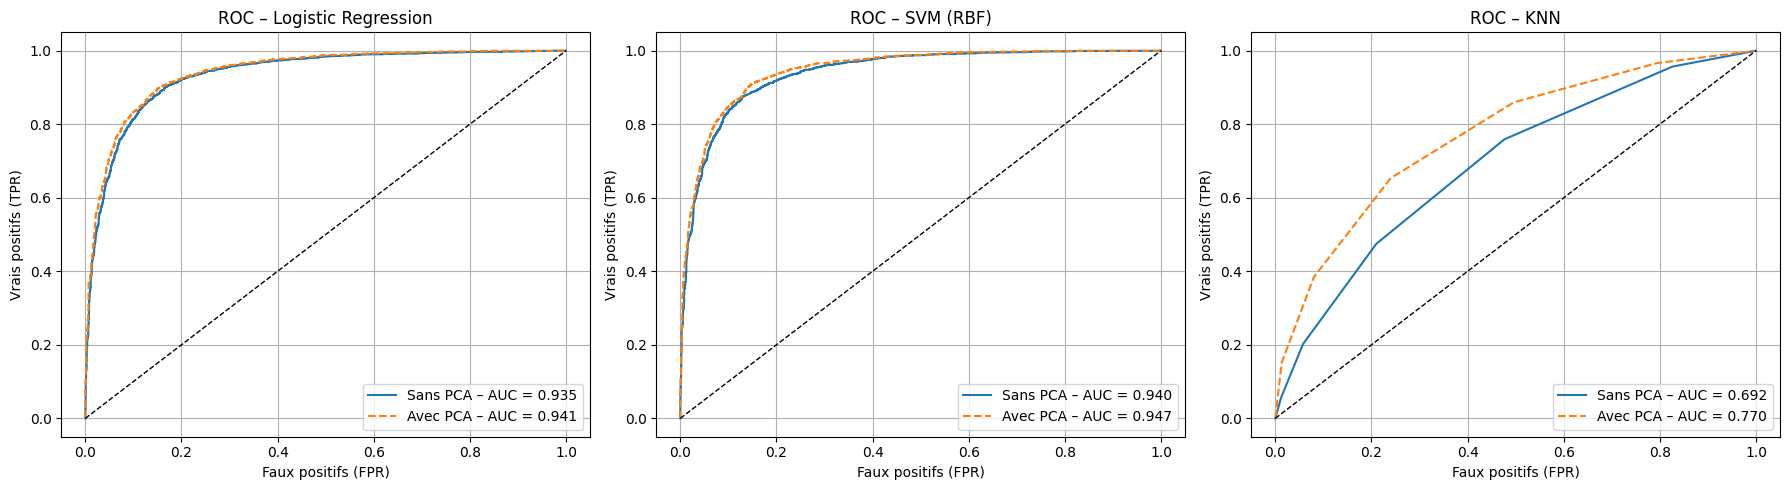

In [31]:
# Courbes ROC 

models_comparaison = {
    "Logistic Regression": (logreg, X_test, logreg_kpca, X_kpca_test),
    "SVM (RBF)": (svm, X_test, svm_kpca, X_kpca_test),
    "KNN": (knn, X_test, knn_kpca, X_kpca_test),
}

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for ax, (name, (model_no_pca, X_eval_no_pca, model_pca, X_eval_pca)) in zip(axes, models_comparaison.items()):
    
    for label, model, X_eval in [("Sans PCA", model_no_pca, X_eval_no_pca), ("Avec PCA", model_pca, X_eval_pca)]:
        # Choix du score selon le modèle
        if hasattr(model, "predict_proba"):
            y_score = model.predict_proba(X_eval)[:, 1]
        elif hasattr(model, "decision_function"):
            y_score = model.decision_function(X_eval)
        else:
            continue  # Évite une erreur si le modèle ne fournit aucun score

        # Calcul des métriques ROC
        fpr, tpr, _ = roc_curve(y_test, y_score)
        auc_score = auc(fpr, tpr)
        linestyle = '-' if label == "Sans PCA" else '--'
        ax.plot(fpr, tpr, linestyle=linestyle, label=f"{label} – AUC = {auc_score:.3f}")

    # Ligne diagonale (aléatoire)
    ax.plot([0, 1], [0, 1], 'k--', lw=1)
    ax.set_title(f"ROC – {name}")
    ax.set_xlabel("Faux positifs (FPR)")
    ax.set_ylabel("Vrais positifs (TPR)")
    ax.grid(True)
    ax.legend(loc="lower right")

plt.tight_layout()
plt.show()

## **Étape 9**: Analyse comparative de l’impact du nombre de composantes principales sur les performances des modèles

Évaluation Kernel PCA: 100%|██████████| 15/15 [9:32:13<00:00, 2288.92s/it]  



Accuracy des modèles :
+-------------------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+
| Modèle            |       50 |      100 |      200 |      300 |      500 |      700 |     1000 |     1300 |     1600 |     1800 |     2000 |     2429 |     3000 |     4000 |     5000 |   aucune |
+===================+==========+==========+==========+==========+==========+==========+==========+==========+==========+==========+==========+==========+==========+==========+==========+==========+
| KNN (avec PCA)    |   0.6707 |   0.6828 |   0.6822 |   0.6743 |   0.6512 |   0.6627 |   0.6833 |   0.6895 |   0.6848 |   0.6823 |   0.7002 |   0.7093 |   0.7105 |   0.7117 |   0.708  | nan      |
+-------------------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+---------

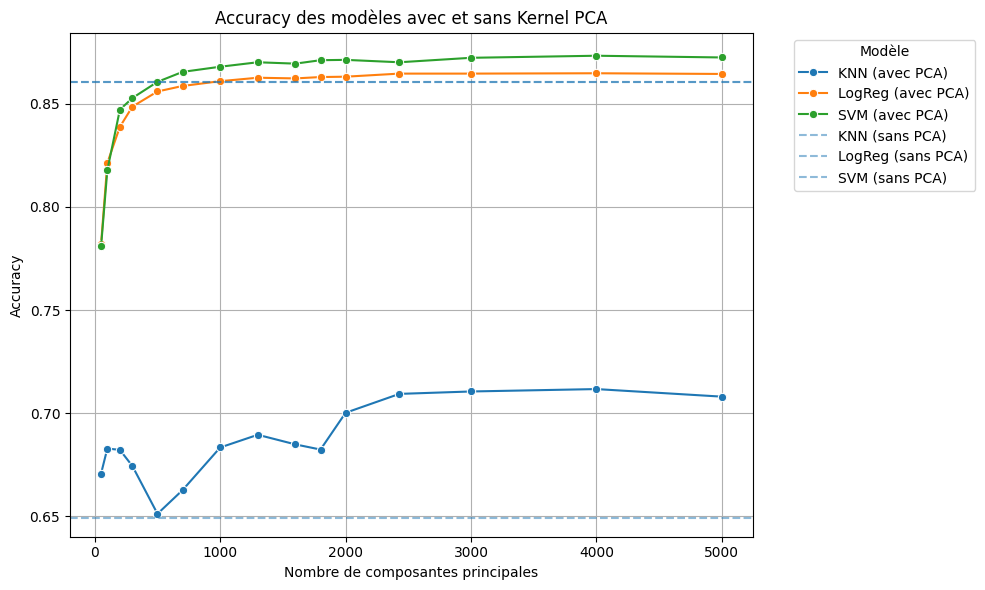

In [28]:

from tqdm import tqdm
from tabulate import tabulate

# Données sources déjà prétraitées
X_text2 = df['processed_review']
y2 = df['label'].values

# Split train/test
X_text2_train, X_text2_test, y2_train, y2_test = train_test_split(X_text2, y2, test_size=0.3, random_state=42)

# Vectorisation
vectorizer9 = CountVectorizer(max_features=10000)
X9_train = vectorizer9.fit_transform(X_text2_train).toarray()
X9_test = vectorizer9.transform(X_text2_test).toarray()

# Liste des composantes principales à tester
composantes_test = [50, 100, 200, 300, 500, 700, 1000, 1300, 1600, 1800, 2000, 2429, 3000, 4000, 5000]
results9 = []

# Modèles à comparer
model_dict = {
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "LogReg": LogisticRegression(max_iter=1000),
    "SVM": SVC(kernel='rbf')
}

# Évaluation SANS PCA (1 seule fois)
for name, model in model_dict.items():
    model.fit(X9_train, y2_train)
    y_pred = model.predict(X9_test)
    results9.append({
        'Modèle': f"{name} (sans PCA)",
        'Composantes': 'aucune',
        'Accuracy': accuracy_score(y2_test, y_pred),
        'F1-score': f1_score(y2_test, y_pred)
    })

# Évaluation AVEC PCA pour plusieurs dimensions
for n_comp in tqdm(composantes_test, desc="Évaluation Kernel PCA"):
    kpca = KernelPCA(n_components=n_comp, kernel='cosine')
    X9_kpca_train = kpca.fit_transform(X9_train)
    X9_kpca_test = kpca.transform(X9_test)

    for name, model in model_dict.items():
        model.fit(X9_kpca_train, y2_train)
        y_pred_pca = model.predict(X9_kpca_test)
        results9.append({
            'Modèle': f"{name} (avec PCA)",
            'Composantes': n_comp,
            'Accuracy': accuracy_score(y2_test, y_pred_pca),
            'F1-score': f1_score(y2_test, y_pred_pca)
        })

# Résultats en DataFrame
df_res9 = pd.DataFrame(results9)

# Tableaux pivots
df_accuracy9 = df_res9.pivot(index='Modèle', columns='Composantes', values='Accuracy')
df_f1_9 = df_res9.pivot(index='Modèle', columns='Composantes', values='F1-score')

# Affichage lisible (console)
print("\nAccuracy des modèles :")
print(tabulate(df_accuracy9.round(4), headers="keys", tablefmt="grid"))

print("\nF1-score des modèles :")
print(tabulate(df_f1_9.round(4), headers="keys", tablefmt="grid"))

# Courbe Accuracy
df_plot9 = df_res9.copy()
df_plot9['Composantes_num'] = pd.to_numeric(df_plot9['Composantes'], errors='coerce')

plt.figure(figsize=(10, 6))
sns.lineplot(
    data=df_plot9[df_plot9['Composantes_num'].notna()],
    x='Composantes_num',
    y='Accuracy',
    hue='Modèle',
    marker='o'
)

for _, row in df_plot9[df_plot9['Composantes'] == 'aucune'].iterrows():
    plt.axhline(y=row['Accuracy'], linestyle='--', label=row['Modèle'], alpha=0.5)

plt.title("Accuracy des modèles avec et sans Kernel PCA")
plt.xlabel("Nombre de composantes principales")
plt.ylabel("Accuracy")
plt.grid(True)
plt.legend(title="Modèle", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


# **Étape 10** : Interface pour tester le modèle le plus performant 

In [ ]:
# A faire